In [201]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import transforms as T
import torchvision.models as models
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import wandb
from torchvision.utils import make_grid
import imageio

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [202]:
# Utility function for Poisson Image Editing
def poisson_blend(source_img, target_img, mask, center):
    return cv2.seamlessClone(source_img, target_img, mask, center, cv2.NORMAL_CLONE)

In [203]:
def poisson_blend_random_scale(source_path, target_path):
    """
    Perform Poisson blending between a source and target image with a random scaling factor between 0.1 and 0.5.
    
    Args:
        source_path (str): Path to the source image (e.g., tiger).
        target_path (str): Path to the target image (e.g., road).
        output_path (str): Path to save the blended output image.
    
    Returns:
        blended_img (numpy.ndarray): The result of the Poisson blending.
    """
    # Load source and target images
    source_img = cv2.imread(source_path)  # Source image (e.g., tiger)
    target_img = cv2.imread(target_path)  # Target image (e.g., road)
    
    if source_img is None or target_img is None:
        print("Error: One or both images couldn't be loaded.")
        return None

    # Generate a random scale factor between 0.1 and 0.5
    scale_factor = random.uniform(0.1, 0.5)
    print(f"Scaling the source image by a factor of {scale_factor:.2f}")

    # Resize the source image based on the random scale factor
    resized_source_img = cv2.resize(source_img, (0, 0), fx=scale_factor, fy=scale_factor)
    
    # Create a white mask for the resized source image
    resized_mask = np.ones(resized_source_img.shape[:2], dtype=np.uint8) * 255  # Binary mask for Poisson blending

    # Choose a center point where to place the source image on the target image
    center_x = random.randint(resized_source_img.shape[1] // 2, target_img.shape[1] - resized_source_img.shape[1] // 2)
    center_y = random.randint(resized_source_img.shape[0] // 2, target_img.shape[0] - resized_source_img.shape[0] // 2)
    center = (center_x, center_y)

    # Print the center for debugging purposes
    print(f"Placing the source image at the center position: {center}")

    # Perform Poisson blending using seamlessClone
    blended_img = cv2.seamlessClone(resized_source_img, target_img, resized_mask, center, cv2.NORMAL_CLONE)

    # Save the blended image
    output_path = "../datasets/testing_images/blended.jpg"
    cv2.imwrite(output_path, blended_img)
    # print(f"Blended image saved to {output_path}")

    # Optionally, display the blended image
    cv2.imshow('Blended Image', blended_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return blended_img

In [204]:
# source_img = '../datasets/testing_images/tiger-4.jpg'
# target_img = '../datasets/testing_images/road.jpg'

# # print(source_img.shape)
# # print(target_img.shape)

# blended_img = poisson_blend_random_scale(source_img, target_img)

# # # Create a binary mask
# # mask = np.zeros_like(source_img[:, :, 0])
# # mask[50:150, 50:150] = 255  # Mask the area to blend

# # # Define the center where the source will be blended on the target
# # center = (100, 100)

# # # Apply Poisson blending
# # result = poisson_blend(source_img, target_img, mask, center)

# # # Show the result
# # cv2.imshow('Blended Image', result)
# # cv2.waitKey(0)
# # cv2.destroyAllWindows()

In [213]:
def nsa_patch_extraction(img_dest, img_src=None, same=False):
    """
        Extracts a patch from the source image and blends it into the destination image using a basic overlap technique.

        Parameters:
        - ima_dest: Destination image (numpy array of shape [H, W, C]).
        - ima_src: Source image (numpy array of shape [H, W, C]), if None, uses ima_dest.
        - same: If True, uses ima_dest as both source and destination.
        
        Returns:
        - patchex: Destination image with blended patch (numpy array of shape [H, W, C]).
        - bbox: Bounding box coordinates of the patch in the form (x_min, y_min, x_max, y_max).
    """
    # Define width bounds for the patch as a fraction of the image dimensions
    width_bounds_pct = ((0.05, 0.2), (0.05, 0.2))
    print("width_bounds_pct: ", width_bounds_pct)

    # If same is True or ima_src is None, use ima_dest as the source for patch extraction
    img_src = img_dest.copy() if same or img_src is None else img_src
    print("img_src: ", img_src.shape)

    # Get the height and width of the destination image
    dims = np.array(img_dest.shape[:2])
    print("dims: ", dims)
    
    # Calculate the minimum and maximum height for the patch as a fraction of the image height
    min_width_dim1 = int(width_bounds_pct[0][0] * dims[0])  
    max_width_dim1 = int(width_bounds_pct[0][1] * dims[0])
    print("min_width_dim1: ",min_width_dim1)
    print("max_width_dim1: ", max_width_dim1)

    # Calculate the minimum and maximum width for the patch as a fraction of the image width
    min_width_dim2 = int(width_bounds_pct[1][0] * dims[1])  
    max_width_dim2 = int(width_bounds_pct[1][1] * dims[1])
    print("min_width_dim2: ",min_width_dim2)
    print("max_width_dim2: ", max_width_dim2)

    patch_height = np.random.randint(min_width_dim1, max_width_dim1)
    print("patch_height: ",patch_height)
    patch_width = np.random.randint(min_width_dim2, max_width_dim2)
    print("patch_width: ", patch_width)

    # Define a random position for the patch within the bounds of the destination image
    y_center = np.random.randint(patch_height // 2, dims[0] - patch_height // 2)
    x_center = np.random.randint(patch_width // 2, dims[1] - patch_width // 2)

    # Calculate bounding box coordinates
    y_min = max(0, y_center - patch_height // 2)
    y_max = min(dims[0], y_center + patch_height // 2)
    x_min = max(0, x_center - patch_width // 2)
    x_max = min(dims[1], x_center + patch_width // 2)

    # Check dimensions again to ensure we have a valid patch size
    # if y_min >= y_max or x_min >= x_max:
    #     raise ValueError("Invalid patch dimensions after bounds check; please verify calculations.")
    
    # Extract patch from the source image
    patch = img_src[y_min:y_max, x_min:x_max]
    if patch.shape[0] == 0 or patch.shape[1] == 0:
        raise ValueError("Invalid patch dimensions; please check bounding box calculations.")

    # Blend the patch into the destination image with simple alpha blending
    blended_image = img_dest.copy()

    # Alpha blending for patch overlay
    alpha = 0.5  # Blend factor
    blended_image[y_min:y_max, x_min:x_max] = (
        alpha * patch + (1 - alpha) * blended_image[y_min:y_max, x_min:x_max]
    ).astype(np.uint8)

    bbox = (x_min, y_min, x_max, y_max)
    return blended_image, bbox

(1318, 1920, 3)
(699, 1049, 3)
width_bounds_pct:  ((0.05, 0.2), (0.05, 0.2))
img_src:  (699, 1049, 3)
dims:  [1318 1920]
min_width_dim1:  65
max_width_dim1:  263
min_width_dim2:  96
max_width_dim2:  384
patch_height:  141
patch_width:  284
Image saved to ../datasets/testing_images/new_blended_img.jpg


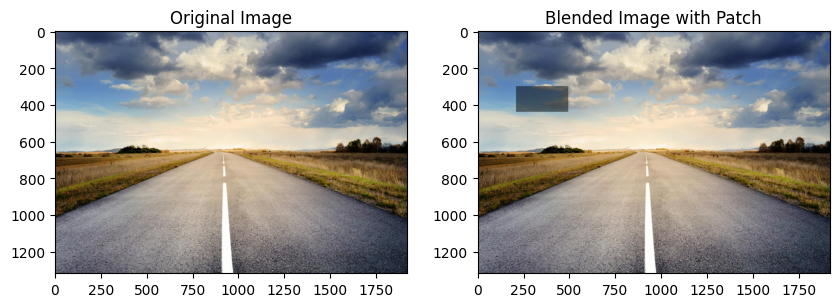

In [214]:
img_1 = "../datasets/testing_images/road.jpg"
img_2 = "../datasets/testing_images/tiger-4.jpg"
ima_dest = plt.imread(img_1)
print(ima_dest.shape)
img_src = plt.imread(img_2)
print(img_src.shape)

if img_src.ndim == 2:
    img_src = np.stack([img_src]*3, axis=-1)

# Apply NSA patch extraction
blended_image, bbox = nsa_patch_extraction(ima_dest, img_src)

output_path = "../datasets/testing_images/new_blended_img.jpg"
imageio.imsave(output_path, blended_image)
print(f"Image saved to {output_path}")


# Visualize the original and blended image with bounding box
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(ima_dest)
ax[0].set_title("Original Image")
ax[1].imshow(blended_image)
# ax[1].add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], edgecolor='red', facecolor='none'))
ax[1].set_title("Blended Image with Patch")
plt.show()

In [241]:
import numpy as np
import scipy.sparse
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

In [242]:
def adjust_offset_for_realistic_placement(ima_dest, patch_height, patch_width):
    """
    Adjust offset to place the source patch in a realistic area (e.g., on the road or grass).
    Parameters:
    - ima_dest: Destination image (numpy array [H, W, C]).
    - patch_height: Height of the patch to be placed.
    - patch_width: Width of the patch to be placed.
    Returns:
    - offset: (y, x) coordinates for realistic placement of the patch.
    """
    # Set limits to place the patch within the lower half of the destination image
    lower_half_start = ima_dest.shape[0] // 2
    y_offset = random.randint(lower_half_start, ima_dest.shape[0] - patch_height - 10)

    # Ensure the patch stays within the width of the destination image
    x_offset = random.randint(0, ima_dest.shape[1] - patch_width - 10)

    return (y_offset, x_offset)

In [243]:
def poisson_blend(ima_dest, ima_src, mask):
    """
    Perform Poisson blending to seamlessly blend ima_src into ima_dest within the region defined by mask.
    Parameters:
    - ima_dest: Destination image (numpy array [H, W, C]).
    - ima_src: Source image (numpy array [H, W, C]).
    - mask: Binary mask defining the region of the source to blend into the destination.
    Returns:
    - blended_image: Image after Poisson blending.
    """
    h, w = mask.shape
    offset = adjust_offset_for_realistic_placement(ima_dest, h, w)
    y_offset, x_offset = offset
    blended_image = ima_dest.copy()

    for c in range(3):  # Process each color channel separately
        # Extract the destination and source regions based on the mask
        dest_patch = ima_dest[y_offset:y_offset + h, x_offset:x_offset + w, c]
        src_patch = ima_src[:h, :w, c]
        mask_flat = mask.flatten()

        # Laplacian matrix for the interior pixels
        laplacian = scipy.sparse.lil_matrix((h * w, h * w))
        b = np.zeros(h * w)

        # Build the Laplacian matrix and the b vector
        for y in range(h):
            for x in range(w):
                idx = y * w + x
                if mask[y, x]:
                    laplacian[idx, idx] = 4
                    for ny, nx in [(y - 1, x), (y + 1, x), (y, x - 1), (y, x + 1)]:
                        if 0 <= ny < h and 0 <= nx < w:
                            n_idx = ny * w + nx
                            if mask[ny, nx]:
                                laplacian[idx, n_idx] = -1
                            else:
                                b[idx] += dest_patch[ny, nx]
                    b[idx] += (4 * src_patch[y, x] -
                               (src_patch[min(y + 1, h - 1), x] +
                                src_patch[max(y - 1, 0), x] +
                                src_patch[y, min(x + 1, w - 1)] +
                                src_patch[y, max(x - 1, 0)]))
                else:
                    laplacian[idx, idx] = 1
                    b[idx] = dest_patch[y, x]

        # Solve the system
        laplacian = laplacian.tocsc()
        x = scipy.sparse.linalg.spsolve(laplacian, b)

        # Reshape solution and insert back into the blended image
        blended_channel = x.reshape((h, w))
        blended_image[y_offset:y_offset + h, x_offset:x_offset + w, c] = np.clip(blended_channel, 0, 1)

    return blended_image

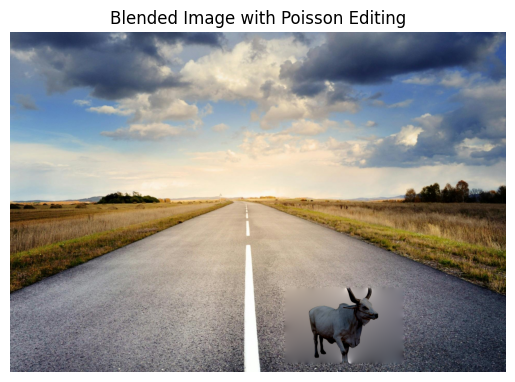

In [246]:
# Example usage
img_1 = "../datasets/testing_images/road.jpg"
img_2 = "../datasets/testing_images/cow2.jpg"
ima_dest = plt.imread(img_1)[:, :, :3]  # Destination image
ima_src = plt.imread(img_2)[:, :, :3]   # Source image

# Resize the source and create a mask
ima_src = np.array(ima_src, dtype=float) / 255.0  # Normalizing for calculations
ima_dest = np.array(ima_dest, dtype=float) / 255.0
h, w = ima_src.shape[:2]
mask = np.zeros((h, w), dtype=np.uint8)
mask[20:-20, 20:-20] = 1  # Define a simple mask (1's for blending area)

# Perform blending
blended_image = poisson_blend(ima_dest, ima_src, mask)

# Display the result
plt.imshow(np.clip(blended_image, 0, 1))
plt.axis('off')
plt.title('Blended Image with Poisson Editing')
plt.show()